In [1]:
from simulators.landscaper import NormalLossDecayLandscape
from ray import air, tune
from ray.tune.schedulers import ASHAScheduler
from ray.air import session
from ray.tune.logger import CSVLoggerCallback
import os
from ray.air.config import RunConfig
import random
import ray


In [22]:
def train_simulator(config):
    values = config['sample_array']
    series = values[:,config['index']]
    n = len(series)

    for epoch in range(n):
        loss = series[epoch]
        session.report({'index':config['index'], 'loss': loss})

class TestTrainble(tune.Trainable):

    def setup(self, config):
        self.index = config.get("index", 0)
        self.values = config.get('sample_array', [])
        self.series = self.values[:,self.index]
        self.internal_training_iteration = 0

    def reset_config(self, new_config):
        if "index" in new_config:
            self.index = new_config.get("index")
            self.series = self.values[:,self.index]
            self.internal_training_iteration = 0
        return True
        
    def step(self):
        loss = self.series[self.training_iteration]
        self.internal_training_iteration += 1
        return {"index":self.index, "loss": loss}
    
    def save_checkpoint(self, dir):
        pass

In [12]:
# generate loss landscape
max_num_epochs = 100
num_samples = 100
landscaper = NormalLossDecayLandscape(
    max_time_steps=max_num_epochs, samples=num_samples)
sim_loss = landscaper.generate_landscape()

config = {}
config['sample_array'] = sim_loss
config['index'] = tune.grid_search(list(range(num_samples)))

src_files = ['raytune_engine.py']
formatted_src_files = [
    os.getcwd() + '/' + file for file in src_files
]
runtime_env = {'includes': formatted_src_files}

In [24]:
ray.init(runtime_env=runtime_env, 
    include_dashboard=False,
    ignore_reinit_error=True,
    _system_config={"num_heartbeats_timeout": 800, "object_timeout_milliseconds":9000000})

scheduler = ASHAScheduler(max_t=max_num_epochs, brackets=3,
                        grace_period=1,
                        reduction_factor=4)

2022-10-12 20:37:27,774	INFO worker.py:1518 -- Started a local Ray instance.


In [25]:
cpus_per_trial=1
gpus_per_trial=0
sched_name="ASHA"

In [26]:
tuner = tune.Tuner(
        tune.with_resources(
            tune.with_parameters(TestTrainble),
            resources={'cpu': cpus_per_trial, 'gpu': gpus_per_trial}
        ),
        tune_config=tune.TuneConfig(
            metric='loss',
            mode='min',
            scheduler=scheduler,
            num_samples=1,
            max_concurrent_trials=16,
            reuse_actors=True,
        ),
        param_space=config,
        run_config=RunConfig(
            local_dir=os.getcwd(),
            name=f"test-run-s-{num_samples}-t-{max_num_epochs}-{sched_name}",
            callbacks=[CSVLoggerCallback()],
            verbose=0,
            sync_config=tune.SyncConfig(
            syncer=None  # Disable syncing
            )
        ),  
    )
results = tuner.fit()

In [23]:
ray.shutdown()

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

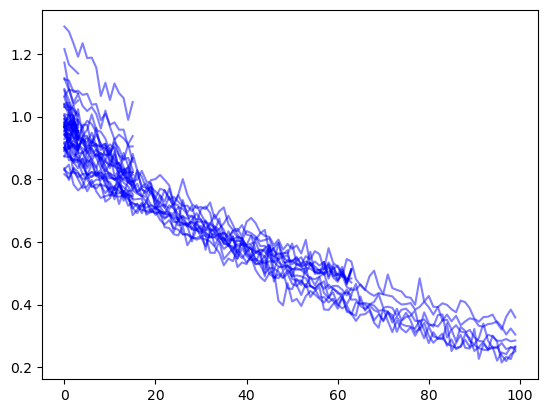

In [29]:
ax = None  # This plots everything on the same plot
dfs = {result.log_dir: result.metrics_dataframe for result in results}
for d in dfs.values():
    ax = d.loss.plot(color="blue", alpha=0.5, ax=ax, legend=False)

In [33]:
import pandas as pd
import numpy as np

true_loss = landscaper.true_loss
ind = np.argpartition(true_loss[0], 4)[:4]
print(ind)


[80 92 15 51]


In [34]:
new_df = pd.concat(dfs.values(), ignore_index=True)
new_df["pid"].nunique()

40

In [41]:
true_loss[0,[1,2,3]]

array([1.24406368, 0.90590922, 1.06139117])

In [54]:
from readline import read_init_file


avgs = []
sums = []
running_sum = 0
for i in range(1, max_num_epochs):
    indices = new_df[new_df["training_iteration"] == i]["index"].unique()
    values = true_loss[i, indices]
    best_arm = np.min(true_loss[i])
    avg = np.average(values - best_arm)
    avgs.append(avg)
    running_sum += avg
    sums.append(running_sum)



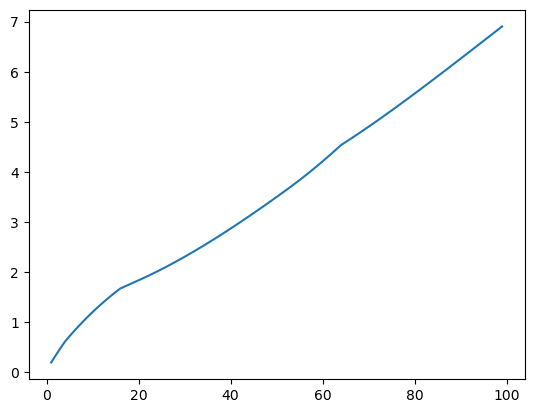

In [55]:
plt.plot(list(range(1, max_num_epochs)), sums)

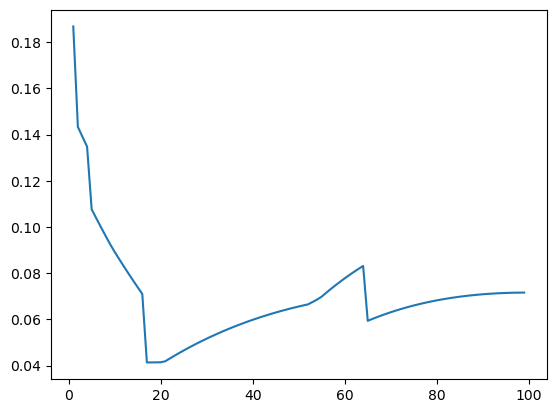

In [56]:
plt.plot(list(range(1, max_num_epochs)), avgs)

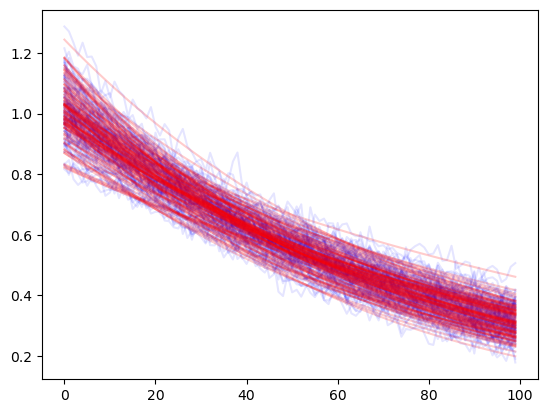

In [58]:
time_range = list(range(max_num_epochs))
plt.plot(time_range, landscaper.simulated_loss, alpha=0.1, color="blue")
plt.plot(time_range, landscaper.true_loss, alpha=0.2, color="red")
plt.show()

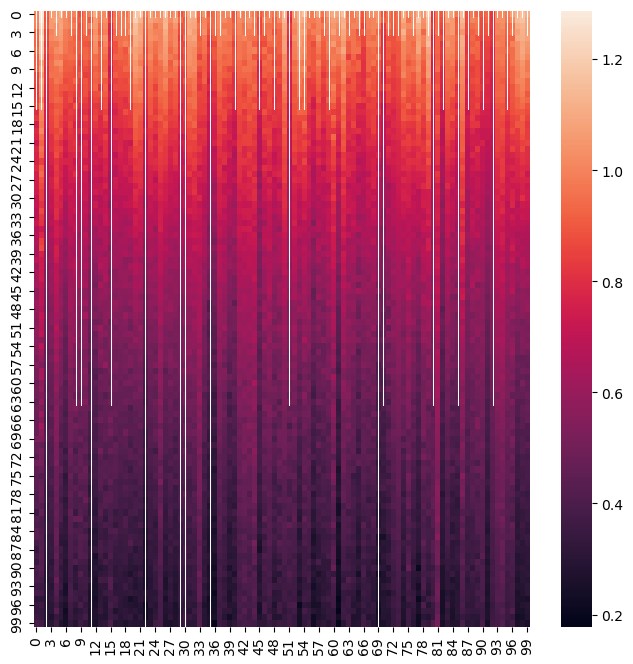

In [86]:
import seaborn as sns

plt.figure(figsize=(8, 8))
sns.heatmap(landscaper.simulated_loss)

totals = new_df.groupby("index")["training_iteration"].max().values
for i in range(len(totals)):
    plt.axvline(i+0.5, 1, 1 - totals[i]/100, linewidth=0.75, color="white")
plt.show()

In [64]:
new_df.groupby("index")["training_iteration"].max().values

array([ 16,  16, 100,   1,   4,   1,   1,   4,  64,  64,   4, 100,   1,
        16,   1,  64,   4,   4,   4,  16,   1,   1, 100,   1,   1,   1,
         1,   1,   1, 100, 100,   1,   1,   4,   1, 100,   4,   4,   1,
         1,  16,   1,   4,   1,   4,  16,   4,   1,  16,   1,   1,  64,
         1,  16,  16,   1,   1,   1,   4,  16,   1,   4,   1,   4,   1,
         4,   4,   1,   1, 100,  64,   4,   4,   4,   1,   1,   4,   1,
         1,   4,  64,   4,  16,   1,   1,  64,   1,  16,   1,   4,  16,
         4,  64,   1,   1,  16,   4,   1,   1,   4])